In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output
import matplotlib
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

In [2]:
# set Scientific Notation Looks in Pandas
# pd.set_option('display.float_format', '{:.5f}'.format)
# pd.reset_option('display.float_format')

# Define functions

In [3]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [4]:
def autolabel(rects, ax, addition=[], away = 1,direction=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    
    if not len(addition):
        addition = ["" for i in range(len(rects))]
    
    if direction == 0:
        for i,rect in enumerate(rects):
            height = rect.get_height().round(3)
            ax.annotate('{} {}'.format(height,addition[i]),
                        xy=(rect.get_x() + rect.get_width() / 2, height + away),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    else:
        for i,rect in enumerate(rects):
            height = rect.get_width().round(3)
            ax.annotate('{} {}'.format(height,addition[i]),
                        xy=( height + away,rect.get_y() ),
                        xytext=(0, 0),  # 3 points horizontal offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    

In [5]:
# set path of input and output
# IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"
# OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"

IN_PATH = "../data/ctracker_model/"
OUT_PATH = "../data/ctracker_model/"

# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

- # 1. CO2 mass
    - ## [1.1. Calculate global, NH and SH total](#co2_mass_total)
    - ## [1.2. Vertical distribution](#vertical_co2_mass)
- # 2. C mass
    - ## [2.1. Calculate global, NH and SH total](#c_mass_total)
    - ## [2.2. Vertical distribution](#Vertical_c_mass)
- # 3. CO2 mole frcation in ppm, including all of levels
    - ## [3.1. Calculate global, NH and SH mean](#co2_molefraction_total)
    - ## [3.2. Zonal CO2 changes with levels in 2017](#co2_molefraction_level)
    - ## [3.3. Vertical distribution](#vertical_co2_molefraction)
    - ## [3.4. If samples (station measurement) present whole global](#sample_molefraction)

# 1. CO2 mass
<a name="co2_mass_total"></a>
## 1.1. Calculate global, NH and SH <font color=red>CO2 mass</font> from surface to 200000m

In [6]:
# load data
arr_co2mass_4d = np.load(IN_PATH+'arr_co2mass_4d.npy') # Gt
arr_co2mass_4d = np.flip(arr_co2mass_4d, 2)

# sum all levels
arr_co2mass_3d = np.sum(arr_co2mass_4d,axis=1)

# make 2D dataframe lon, lat, month1 ... monthn
lat = pd.DataFrame(np.repeat(np.arange(89.5,-90,-1),360))
lon = pd.DataFrame(np.tile(np.arange(-179.5,180,1),(180,1)).flatten())
df_co2mass = pd.concat([lon,lat], axis=1)

for mon in range(arr_co2mass_3d.shape[0]):
    temp_onemonth = arr_co2mass_3d[mon].flatten()
    df_co2mass = pd.concat([df_co2mass, pd.DataFrame(temp_onemonth)],axis=1)

df_co2mass.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

# global, NH and SH co2 mass, the unit is Gt
# global_co2mass = pd.DataFrame([np.sum(arr_co2mass_4d[i]) for i in range(arr_co2mass_4d.shape[0])])
# NH_co2mass = pd.DataFrame([np.sum(arr_co2mass_4d[i,:,0:90,:]) for i in range(arr_co2mass_4d.shape[0])])
# SH_co2mass = pd.DataFrame([np.sum(arr_co2mass_4d[i,:,90:180,:]) for i in range(arr_co2mass_4d.shape[0])])
global_co2mass = df_co2mass.iloc[:,2:].sum(min_count=1)
NH_co2mass = df_co2mass[df_co2mass.lat>0].iloc[:,2:].sum(min_count=1)
SH_co2mass = df_co2mass[df_co2mass.lat<=0].iloc[:,2:].sum(min_count=1)
co2mass_annual = pd.concat([global_co2mass,NH_co2mass,SH_co2mass],axis=1)
co2mass_annual.columns = ["global_co2mass","NH_co2mass","SH_co2mass"]
co2mass_annual["year"] = df_datetime.date.dt.year.tolist()
co2mass_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2mass,2882.555119,2891.471858,2906.742764,2925.793732,2940.666381,2956.560592,2973.273018,2987.656386,3002.379479,3014.290377,3032.175367,3047.735236,3064.027577,3084.789487,3101.052332,3116.840174,3140.625774,3161.222381
NH_co2mass,1441.498462,1445.481081,1452.973875,1462.623729,1470.297798,1478.174865,1487.329036,1493.732802,1501.687083,1507.378362,1516.671329,1524.498848,1533.219918,1543.449444,1551.361261,1559.302475,1571.570729,1582.283987
SH_co2mass,1441.056657,1445.990777,1453.768889,1463.170003,1470.368583,1478.385727,1485.943981,1493.923584,1500.692396,1506.912015,1515.504038,1523.236388,1530.807659,1541.340044,1549.691072,1557.537699,1569.055046,1578.938394


In [7]:
# save memory
del arr_co2mass_4d

In [6]:
# # read co2 mass data, the unit is Gt 
# df_co2mass = pd.read_table(IN_PATH+"CT2018_2000_2017_monthly_co2mass.txt", delimiter="\s+")
# df_co2mass.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

# # global, NH and SH co2 mass, the unit is Gt 
# global_co2mass = df_co2mass.iloc[:,2:].sum(min_count=1)
# NH_co2mass = df_co2mass[df_co2mass.lat>0].iloc[:,2:].sum(min_count=1)
# SH_co2mass = df_co2mass[df_co2mass.lat<=0].iloc[:,2:].sum(min_count=1)
# co2mass_annual = pd.concat([global_co2mass,NH_co2mass,SH_co2mass],axis=1)
# co2mass_annual.columns = ["global_co2mas","NH_co2ma","SH_co2ma"]
# co2mass_annual["year"] = df_datetime.date.dt.year.tolist()
# co2mass_annual.groupby(["year"]).mean().T

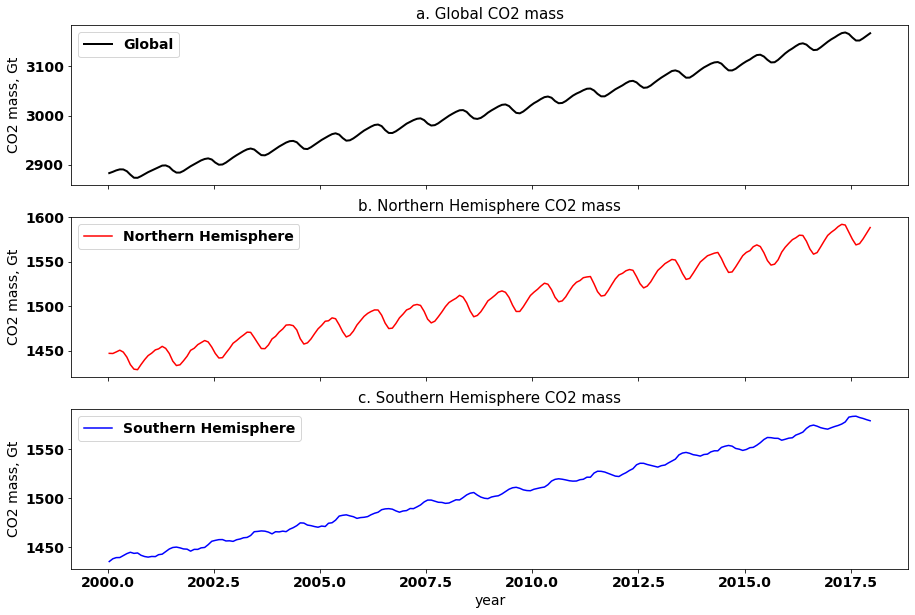

In [8]:
# Plot global, NH and SH CO2 mass from surface to 200000m
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,global_co2mass, 'k', label = "Global", lw=2)
ax1.set_ylabel("CO2 mass, Gt")
ax1.legend()
ax1.set_title("a. Global CO2 mass",fontsize=15)

ax2.plot(x_decimalyear,NH_co2mass, 'r', label = "Northern Hemisphere")
ax2.set_ylabel("CO2 mass, Gt")
ax2.legend()
ax2.set_title("b. Northern Hemisphere CO2 mass",fontsize=15)

ax3.plot(x_decimalyear,SH_co2mass,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2 mass, Gt")
ax3.legend()
ax3.set_title("c. Southern Hemisphere CO2 mass",fontsize=15);

plt.savefig("figure12.png")

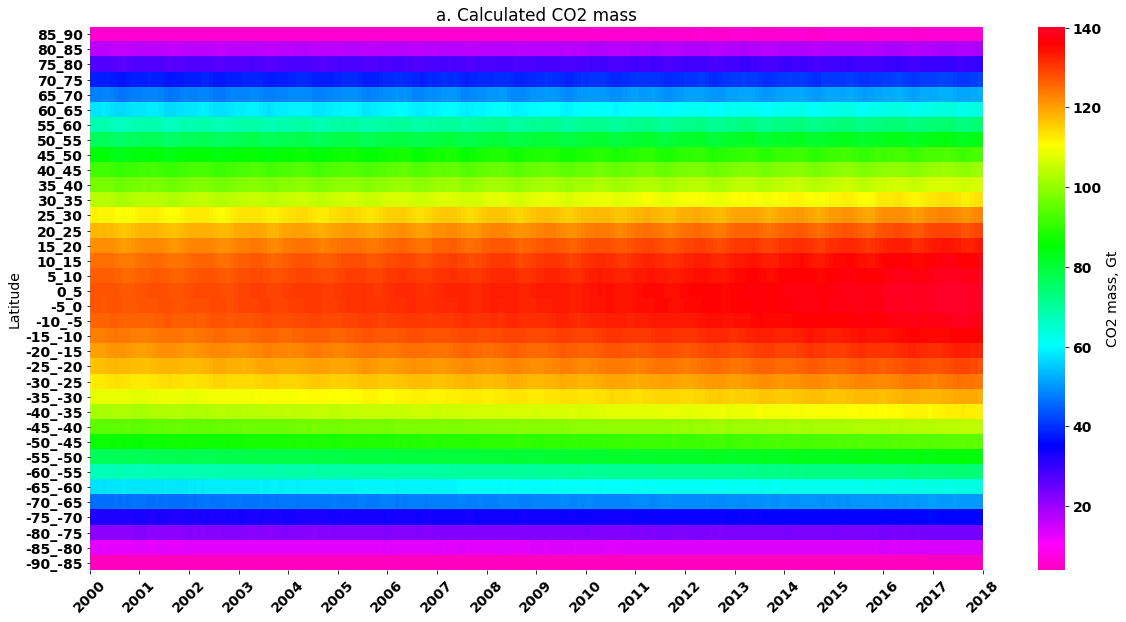

In [9]:
# Plot CO2 mass zonal map
zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2mass.lat) & (df_co2mass.lat<= i+zonal_deg)
    temp_cal = df_co2mass.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,2:].sum()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow_r"), cbar_kws={'label': 'CO2 mass, Gt'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 mass");

plt.savefig("figure13.png")

<a name="vertical_co2_mass"></a>
# 1.2. Vertical CO2 mass distribution from surface to 200000m (level1 to level25)

In [18]:
# load data
arr_co2mass_4d = np.load(IN_PATH+'arr_co2mass_4d.npy') # Gt
arr_co2mass_4d = np.flip(arr_co2mass_4d, 2)

arr_gphdiff_4d = np.load(IN_PATH+'arr_gphdiff_4d.npy') # m
arr_gphdiff_4d = np.flip(arr_gphdiff_4d, 2)


In [19]:
# level altitudes from surface, km
arr_gphdiff_2d = np.mean(arr_gphdiff_4d,axis=(2,3))
level_height  = np.mean(arr_gphdiff_4d,axis=(0,2,3))
level_alt = np.cumsum(level_height)
level_alt_label = []
level_height_label = []
# level_alt = np.around(np.cumsum(level_height),3)
for i in range(25):
    level_alt_label.append(f'~{round(float(level_alt[i])/1000, 2)} km')
    level_height_label.append(f'~{round(float(level_height[i])/1000, 2)} km')
    print(f'Lv {i+1}:     level height ~{round(float(level_height[i])/1000, 2)} km,     altitude ~{round(float(level_alt[i])/1000, 2)} km')
print("Troposphere:   0 km to 7-11 km")
print("Stratosphere:   7-11 km to 50 km")
print("mesosphere:    50 km to 80-85 km")
print("Thermosphere:    80-85 km to 800 km")
print("Exosphere:     800 km to 2000-3000 km")

Lv 1:     level height ~0.05 km,     altitude ~0.05 km
Lv 2:     level height ~0.1 km,     altitude ~0.15 km
Lv 3:     level height ~0.18 km,     altitude ~0.33 km
Lv 4:     level height ~0.27 km,     altitude ~0.6 km
Lv 5:     level height ~0.37 km,     altitude ~0.97 km
Lv 6:     level height ~0.48 km,     altitude ~1.46 km
Lv 7:     level height ~0.6 km,     altitude ~2.06 km
Lv 8:     level height ~0.72 km,     altitude ~2.78 km
Lv 9:     level height ~0.84 km,     altitude ~3.62 km
Lv 10:     level height ~0.96 km,     altitude ~4.57 km
Lv 11:     level height ~1.07 km,     altitude ~5.64 km
Lv 12:     level height ~1.18 km,     altitude ~6.82 km
Lv 13:     level height ~1.28 km,     altitude ~8.1 km
Lv 14:     level height ~1.38 km,     altitude ~9.48 km
Lv 15:     level height ~1.5 km,     altitude ~10.98 km
Lv 16:     level height ~1.65 km,     altitude ~12.63 km
Lv 17:     level height ~1.84 km,     altitude ~14.47 km
Lv 18:     level height ~2.04 km,     altitude ~16.51 km
Lv

In [39]:
# CO2 mass at each level
arr_co2mass_2d = np.sum(arr_co2mass_4d,(2,3))
# CO2 mass in all levels
df_co2mass_levels = pd.DataFrame(arr_co2mass_2d.T)
df_co2mass_levels.columns = [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_co2mass_levels.index = ["lv"+ str(i) for i in range(1,26)]
df_co2mass_levels_annual = df_co2mass_levels[:].T
df_co2mass_levels_annual["year"] = df_datetime.date.dt.year.tolist()
df_co2mass_levels_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
lv1,17.067951,17.130160,17.224489,17.344334,17.428985,17.528525,17.626187,17.706934,17.798378,17.869539,17.977545,18.056267,18.159507,18.289686,18.383811,18.479693,18.627327,18.744416
lv2,35.446362,35.575485,35.773397,36.020631,36.198711,36.400551,36.606372,36.778264,36.963844,37.108243,37.332127,37.514769,37.721808,37.984987,38.177295,38.381150,38.685622,38.929717
lv3,61.320391,61.541484,61.885707,62.312670,62.622062,62.967791,63.326488,63.625892,63.945380,64.193351,64.579561,64.906985,65.260019,65.711840,66.043018,66.397251,66.922141,67.346383
lv4,91.175909,91.501508,92.013099,92.648243,93.108595,93.620347,94.155510,94.601028,95.077313,95.444924,96.018691,96.506577,97.029918,97.702429,98.195122,98.719510,99.498810,100.132354
lv5,121.967078,122.398532,123.081623,123.931071,124.549192,125.231778,125.949028,126.544460,127.182084,127.673074,128.441940,129.091602,129.792802,130.692886,131.353554,132.050657,133.092050,133.943314
lv6,151.138202,151.666772,152.512734,153.565508,154.334454,155.179642,156.069146,156.806471,157.594938,158.203341,159.158705,159.960453,160.830653,161.944456,162.767140,163.624255,164.913540,165.974826
lv7,176.638178,177.246830,178.235802,179.468129,180.369897,181.357557,182.398392,183.260941,184.177766,184.889180,186.010679,186.944670,187.962687,189.260053,190.228153,191.219303,192.723738,193.976320
lv8,196.904060,197.572867,198.674699,200.049834,201.059950,202.159232,203.321850,204.286166,205.303356,206.096294,207.349643,208.389957,209.525214,210.968326,212.054821,213.146485,214.820907,216.231299
lv9,210.851019,211.559594,212.738597,214.209676,215.296429,216.474070,217.720349,218.756373,219.841270,220.691409,222.031976,223.147467,224.359975,225.907025,227.075073,228.235127,230.028554,231.545330
lv10,217.897114,218.622338,219.840251,221.358031,222.486332,223.705653,224.993280,226.067695,227.182200,228.063403,229.447612,230.602343,231.850133,233.452520,234.662204,235.855152,237.708455,239.281061


In [52]:
# save memory
del arr_co2mass_4d
del arr_gphdiff_4d

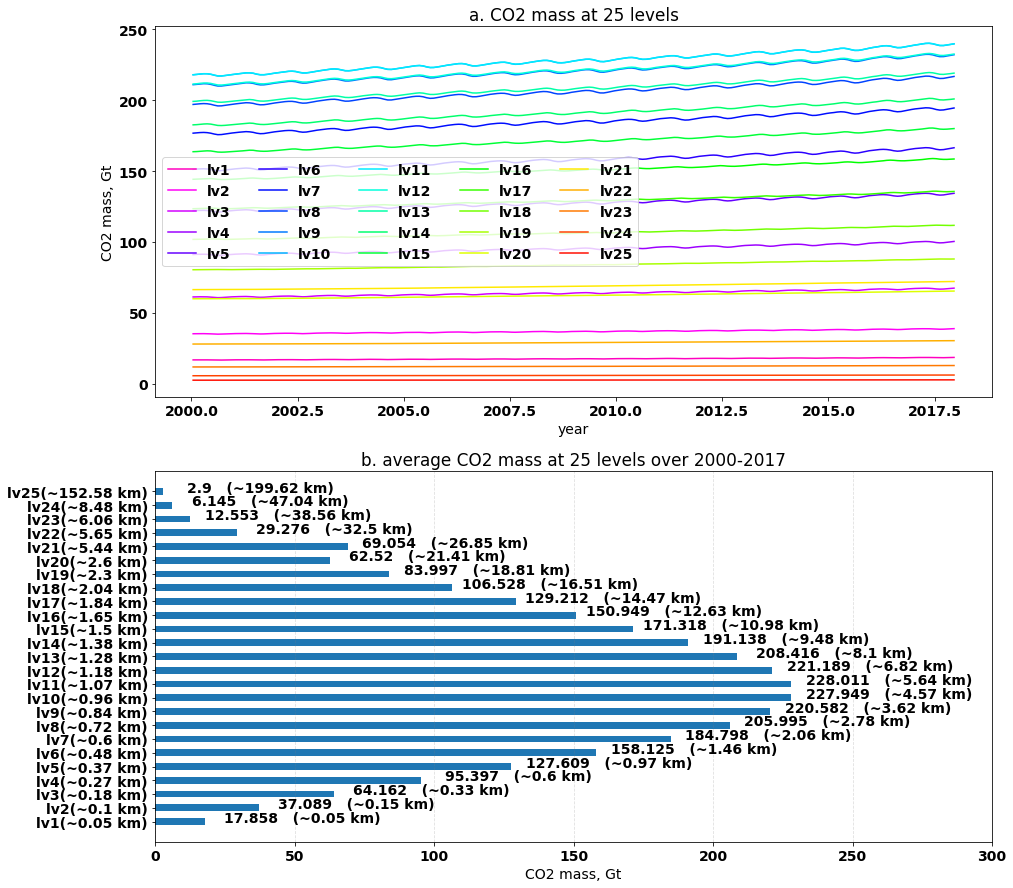

In [51]:
# plot co2 in all levels
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots( nrows=2, ncols=1, figsize = (15,15))
(ax1,ax2) = axis
cmap=plt.get_cmap("gist_rainbow_r")

for i in range(25):
    ax1.plot(x_decimalyear,df_co2mass_levels.iloc[i,:], label = "lv"+str(i+1), color=cmap(i/25))
ax1.legend(ncol=5)
ax1.set_xlabel("year")
ax1.set_ylabel("CO2 mass, Gt")
ax1.set_title("a. CO2 mass at 25 levels")

pos = np.arange(df_co2mass_levels.shape[0])
rects = ax2.barh(pos, df_co2mass_levels.mean(axis=1),
                     align='center',
                     height=0.5,
                     tick_label=df_co2mass_levels.index.to_list())
ax2.set_xlabel("CO2 mass, Gt")
ax2.set_xlim([0,300])
ax2.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
ax2.set_title("b. average CO2 mass at 25 levels over 2000-2017")
yticklabels = [item.get_text() for item in ax2.get_yticklabels()]
yticklabels = [yticklabels[i] + "("+ level_height_label[i] + ")" for i in range(len(yticklabels))]
ax2.set_yticklabels(yticklabels)
autolabel(rects, ax2, addition=["  ("+level_alt_label[i]+")" for i in range(len(level_alt_label))], away=35, direction=1)


# 2. C mass
<a name="c_mass_total"></a>
# 2.1. Calculate global, NH and SH <font color=red>C mass</font>  from surface to 200000m 

In [60]:
# load data
arr_cmass_4d = np.load(IN_PATH+'arr_cmass_4d.npy') # Gt
arr_cmass_4d = np.flip(arr_cmass_4d, 2)

# sum all levels
arr_cmass_3d = np.sum(arr_cmass_4d,axis=1)

# make 2D dataframe lon, lat, month1 ... monthn
lat = pd.DataFrame(np.repeat(np.arange(89.5,-90,-1),360))
lon = pd.DataFrame(np.tile(np.arange(-179.5,180,1),(180,1)).flatten())
df_cmass = pd.concat([lon,lat], axis=1)

for mon in range(arr_cmass_3d.shape[0]):
    temp_onemonth = arr_cmass_3d[mon].flatten()
    df_cmass = pd.concat([df_cmass, pd.DataFrame(temp_onemonth)],axis=1)

df_cmass.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

# global, NH and SH C mass, the unit is Gt
global_cmass = df_cmass.iloc[:,2:].sum(min_count=1)
NH_cmass = df_cmass[df_cmass.lat>0].iloc[:,2:].sum(min_count=1)
SH_cmass = df_cmass[df_cmass.lat<=0].iloc[:,2:].sum(min_count=1)
cmass_annual = pd.concat([global_cmass,NH_cmass,SH_cmass],axis=1)
cmass_annual.columns = ["global_cmass","NH_cmass","SH_cmass"]
cmass_annual["year"] = df_datetime.date.dt.year.tolist()
cmass_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_cmass,786.711116,789.144685,793.312443,798.511861,802.570926,806.908797,811.469976,815.395506,819.413754,822.664493,827.545691,831.792312,836.238842,841.905212,846.343692,850.652532,857.144133,862.765388
NH_cmass,393.415847,394.502789,396.547733,399.181385,401.275803,403.425624,405.923994,407.671719,409.842613,411.395885,413.932135,416.068432,418.448599,421.240456,423.399761,425.567089,428.915358,431.839236
SH_cmass,393.295269,394.641896,396.764710,399.330475,401.295122,403.483173,405.545982,407.723787,409.571141,411.268609,413.613556,415.723880,417.790242,420.664756,422.943931,425.085444,428.228774,430.926152


In [61]:
# save memory
del arr_cmass_4d

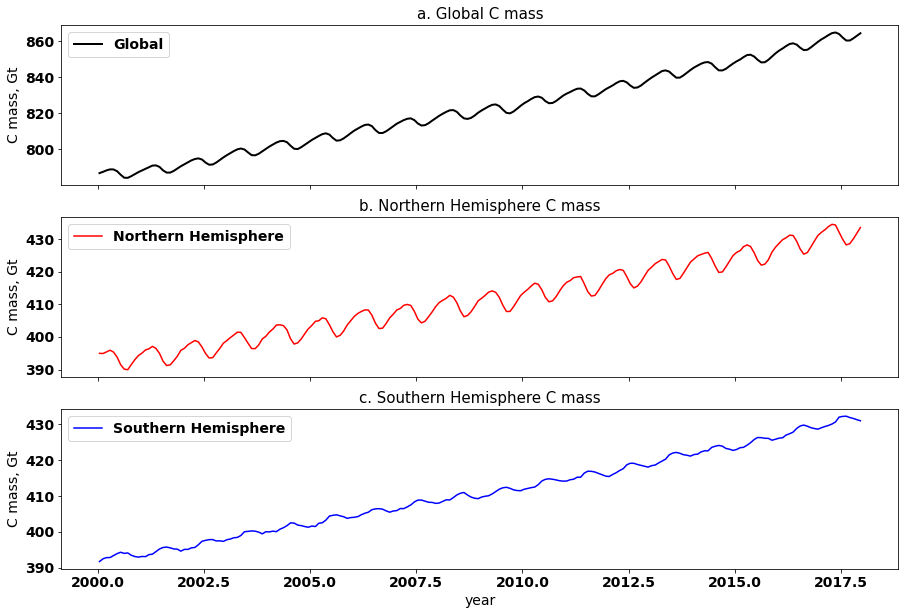

In [62]:
# Plot global, NH and SH C mass from surface to 200000m
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,global_cmass, 'k', label = "Global", lw=2)
ax1.set_ylabel("C mass, Gt")
ax1.legend()
ax1.set_title("a. Global C mass",fontsize=15)

ax2.plot(x_decimalyear,NH_cmass, 'r', label = "Northern Hemisphere")
ax2.set_ylabel("C mass, Gt")
ax2.legend()
ax2.set_title("b. Northern Hemisphere C mass",fontsize=15)

ax3.plot(x_decimalyear,SH_cmass,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("C mass, Gt")
ax3.legend()
ax3.set_title("c. Southern Hemisphere C mass",fontsize=15);

# plt.savefig("figure12.png")

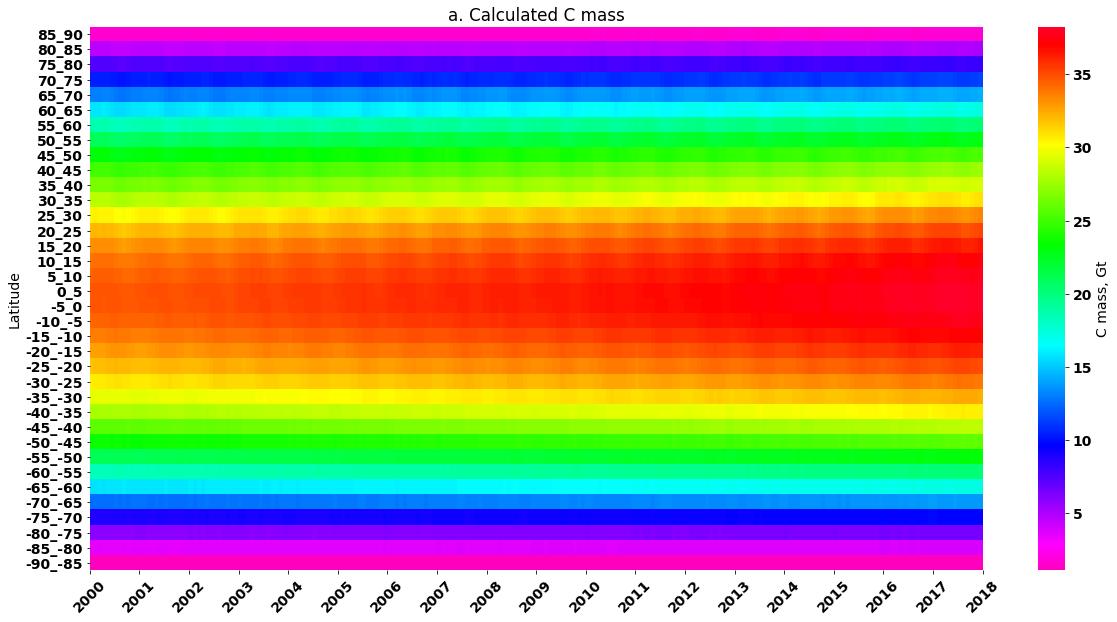

In [63]:
# Plot C mass zonal map
zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_cmass.lat) & (df_cmass.lat<= i+zonal_deg)
    temp_cal = df_cmass.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,2:].sum()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow_r"), cbar_kws={'label': 'C mass, Gt'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated C mass");

<a name="Vertical_c_mass"></a>
# 2.2. Vertical C mass distribution from surface to 200000m (level1 to level25)

In [64]:
# load data
arr_cmass_4d = np.load(IN_PATH+'arr_cmass_4d.npy') # Gt
arr_cmass_4d = np.flip(arr_cmass_4d, 2)


In [65]:
# C mass at each level
arr_cmass_2d = np.sum(arr_cmass_4d,(2,3))
# C mass in all levels
df_cmass_levels = pd.DataFrame(arr_cmass_2d.T)
df_cmass_levels.columns = [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_cmass_levels.index = ["lv"+ str(i) for i in range(1,26)]
df_cmass_levels_annual = df_cmass_levels[:].T
df_cmass_levels_annual["year"] = df_datetime.date.dt.year.tolist()
df_cmass_levels_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
lv1,4.658210,4.675188,4.700933,4.733641,4.756744,4.783911,4.810564,4.832602,4.857559,4.876981,4.906458,4.927942,4.956119,4.991648,5.017336,5.043505,5.083797,5.115753
lv2,9.674072,9.709313,9.763327,9.830803,9.879405,9.934491,9.990664,10.037577,10.088226,10.127636,10.188738,10.238585,10.295090,10.366918,10.419403,10.475039,10.558136,10.624755
lv3,16.735650,16.795991,16.889937,17.006464,17.090904,17.185261,17.283157,17.364870,17.452066,17.519742,17.625147,17.714508,17.810859,17.934170,18.024556,18.121234,18.264488,18.380272
lv4,24.883861,24.972724,25.112348,25.285693,25.411332,25.551001,25.697058,25.818649,25.948638,26.048967,26.205560,26.338715,26.481546,26.665088,26.799555,26.942671,27.155359,27.328267
lv5,33.287431,33.405185,33.591615,33.823447,33.992146,34.178438,34.374191,34.536697,34.710718,34.844720,35.054560,35.231867,35.423239,35.668892,35.849202,36.039456,36.323675,36.556003
lv6,41.248857,41.393115,41.623996,41.911321,42.121183,42.351852,42.594617,42.795849,43.011039,43.177085,43.437824,43.656638,43.894135,44.198115,44.422643,44.656568,45.008442,45.298090
lv7,48.208347,48.374461,48.644373,48.980702,49.226813,49.496367,49.780433,50.015841,50.266062,50.460223,50.766304,51.021210,51.299049,51.653128,51.917343,52.187849,52.598442,52.940298
lv8,53.739341,53.921873,54.222586,54.597890,54.873573,55.173590,55.490894,55.754076,56.031689,56.248099,56.590165,56.874089,57.183925,57.577781,57.874309,58.172247,58.629233,59.014159
lv9,57.545765,57.739151,58.060926,58.462415,58.759013,59.080417,59.420553,59.703306,59.999398,60.231419,60.597288,60.901730,61.232649,61.654872,61.973658,62.290261,62.779726,63.193687
lv10,59.468796,59.666725,59.999119,60.413354,60.721292,61.054071,61.405492,61.698723,62.002895,62.243394,62.621174,62.936325,63.276874,63.714200,64.044348,64.369930,64.875736,65.304934


In [66]:
# save memory
del arr_cmass_4d

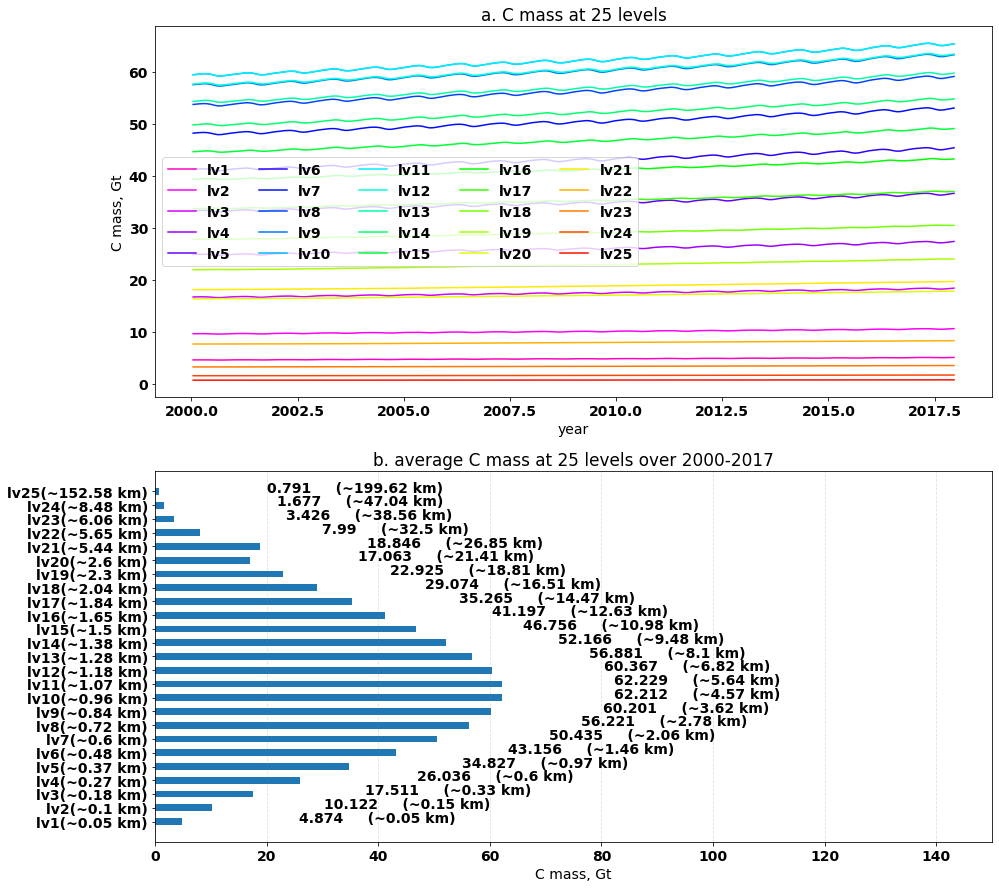

In [68]:
# plot co2 in all levels
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots( nrows=2, ncols=1, figsize = (15,15))
(ax1,ax2) = axis
cmap=plt.get_cmap("gist_rainbow_r")

for i in range(25):
    ax1.plot(x_decimalyear,df_cmass_levels.iloc[i,:], label = "lv"+str(i+1), color=cmap(i/25))
ax1.legend(ncol=5)
ax1.set_xlabel("year")
ax1.set_ylabel("C mass, Gt")
ax1.set_title("a. C mass at 25 levels")

pos = np.arange(df_cmass_levels.shape[0])
rects = ax2.barh(pos, df_cmass_levels.mean(axis=1),
                     align='center',
                     height=0.5,
                     tick_label=df_cmass_levels.index.to_list())
ax2.set_xlabel("C mass, Gt")
ax2.set_xlim([0,150])
ax2.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
ax2.set_title("b. average C mass at 25 levels over 2000-2017")
yticklabels = [item.get_text() for item in ax2.get_yticklabels()]
yticklabels = [yticklabels[i] + "("+ level_height_label[i] + ")" for i in range(len(yticklabels))]
ax2.set_yticklabels(yticklabels)
autolabel(rects, ax2, addition=["    ("+level_alt_label[i]+")" for i in range(len(level_alt_label))], away=35, direction=1)


# 3. CO2 mole frcation in ppm, including all of levels
<a name="co2_molefraction_total"></a>
# 3.1. Calculate global, NH and SH <font color=red>CO2 mole fractoin</font> from surface to 200000m

In [7]:
# load data
arr_co2ppm_4d = np.load(IN_PATH+'arr_co2ppm_4d.npy') # ppm
arr_co2ppm_4d = np.flip(arr_co2ppm_4d, 2)

arr_s_4d = np.load(IN_PATH+'arr_s_4d.npy') # km2
arr_s_4d = np.flip(arr_s_4d, 2)

arr_gphdiff_4d = np.load(IN_PATH+'arr_gphdiff_4d.npy') # m
arr_gphdiff_4d = np.flip(arr_gphdiff_4d, 2)

arr_v_4d = arr_s_4d * arr_gphdiff_4d/1000

# volumn weighted average CO2 mole fraction
arr_v_3d = np.sum(arr_v_4d,axis=1)
arr_co2ppm_3d = np.sum(arr_v_4d*arr_co2ppm_4d,axis=1)/arr_v_3d

arr_v_3d_lv1_3 = np.sum(arr_v_4d[:,0:3,],axis=1)
arr_co2ppm_3d_lv1_3 = np.sum(arr_v_4d[:,0:3,]*arr_co2ppm_4d[:,0:3,],axis=1)/arr_v_3d_lv1_3


# make 2D dataframe lon, lat, month1 ... monthn
lat = pd.DataFrame(np.repeat(np.arange(89.5,-90,-1),360))
lon = pd.DataFrame(np.tile(np.arange(-179.5,180,1),(180,1)).flatten())
df_co2ppm = pd.concat([lon,lat], axis=1)
df_co2ppm_lv1_3 = pd.concat([lon,lat], axis=1)

for mon in range(arr_co2ppm_3d.shape[0]):
    temp_onemonth = arr_co2ppm_3d[mon].flatten()
    df_co2ppm = pd.concat([df_co2ppm, pd.DataFrame(temp_onemonth)],axis=1)
    
    temp_onemonth = arr_co2ppm_3d_lv1_3[mon].flatten()
    df_co2ppm_lv1_3 = pd.concat([df_co2ppm_lv1_3, pd.DataFrame(temp_onemonth)],axis=1)

df_co2ppm.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_co2ppm_lv1_3.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

# global, NH and SH CO2 mole fraction, the unit is ppm, first 3 levels
global_co2ppm = df_co2ppm_lv1_3.iloc[:,2:].mean()
NH_co2ppm = df_co2ppm_lv1_3[df_co2ppm_lv1_3.lat>0].iloc[:,2:].mean()
SH_co2ppm = df_co2ppm_lv1_3[df_co2ppm_lv1_3.lat<=0].iloc[:,2:].mean()
co2ppm_annual_lv1_3 = pd.concat([global_co2ppm,NH_co2ppm,SH_co2ppm],axis=1)
co2ppm_annual_lv1_3.columns = ["global_co2ppm","NH_co2ppm","SH_co2ppm"]
co2ppm_annual_lv1_3["year"] = df_datetime.date.dt.year.tolist()

# global, NH and SH CO2 mole fraction, the unit is ppm
global_co2ppm = df_co2ppm.iloc[:,2:].mean()
NH_co2ppm = df_co2ppm[df_co2ppm.lat>0].iloc[:,2:].mean()
SH_co2ppm = df_co2ppm[df_co2ppm.lat<=0].iloc[:,2:].mean()
co2ppm_annual = pd.concat([global_co2ppm,NH_co2ppm,SH_co2ppm],axis=1)
co2ppm_annual.columns = ["global_co2ppm","NH_co2ppm","SH_co2ppm"]
co2ppm_annual["year"] = df_datetime.date.dt.year.tolist()
co2ppm_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2ppm,365.207395,366.283080,367.315218,368.465005,369.627915,371.074853,372.691767,374.408791,376.067508,377.926703,379.991008,382.091426,383.965765,386.058517,388.173047,390.307248,392.412208,394.475837
NH_co2ppm,365.619613,366.428658,367.438274,368.561240,369.716507,371.194068,372.752977,374.534841,376.167896,378.042358,380.105959,382.284706,384.067268,386.192586,388.326679,390.477515,392.560883,394.627989
SH_co2ppm,364.795178,366.137503,367.192162,368.368769,369.539323,370.955637,372.630557,374.282740,375.967120,377.811048,379.876058,381.898146,383.864261,385.924447,388.019416,390.136982,392.263533,394.323685


In [8]:
co2ppm_annual_lv1_3.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2ppm,369.458765,370.836218,372.868143,375.471747,377.305030,379.374881,381.576675,383.301305,385.327081,386.773268,389.093544,391.026098,393.165288,395.914973,397.917506,400.040713,403.215286,405.787312
NH_co2ppm,371.261911,372.623871,374.553578,377.372625,379.136475,381.235095,383.766922,385.237708,387.395917,388.743824,391.345767,393.411330,395.503279,398.214422,400.226638,402.281760,405.554207,408.467755
SH_co2ppm,367.655618,369.048565,371.182708,373.570869,375.473584,377.514667,379.386429,381.364901,383.258244,384.802713,386.841320,388.640865,390.827297,393.615524,395.608374,397.799665,400.876365,403.106870


In [9]:
# save memory
del arr_s_4d
del arr_gphdiff_4d
# del arr_co2ppm_4d
# del arr_v_4d

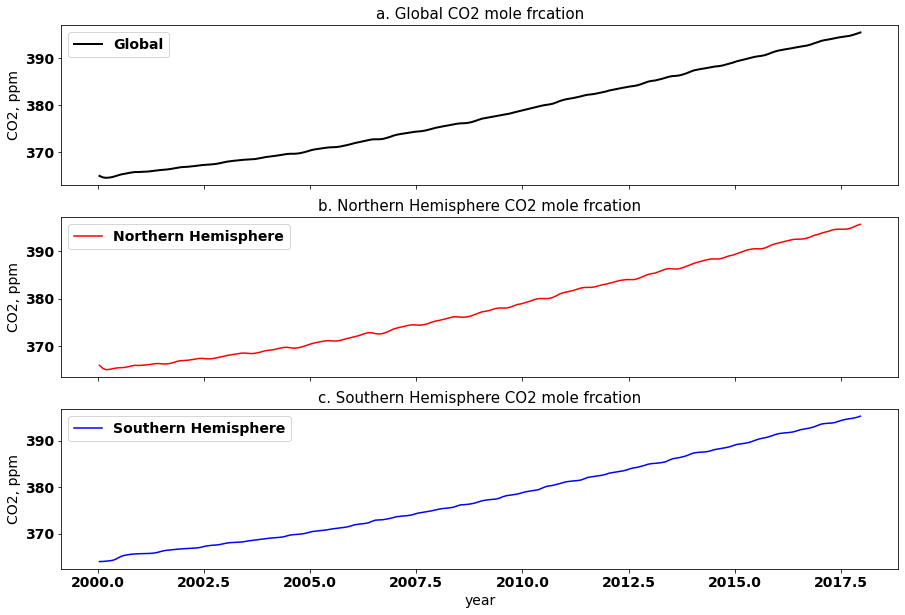

In [10]:
# Plot global, NH and SH CO2 mole fraction from surface to 200000m
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,global_co2ppm, 'k', label = "Global", lw=2)
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Global CO2 mole frcation",fontsize=15)

ax2.plot(x_decimalyear,NH_co2ppm, 'r', label = "Northern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Northern Hemisphere CO2 mole frcation",fontsize=15)

ax3.plot(x_decimalyear,SH_co2ppm,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Southern Hemisphere CO2 mole frcation",fontsize=15);

# plt.savefig("figure12.png")

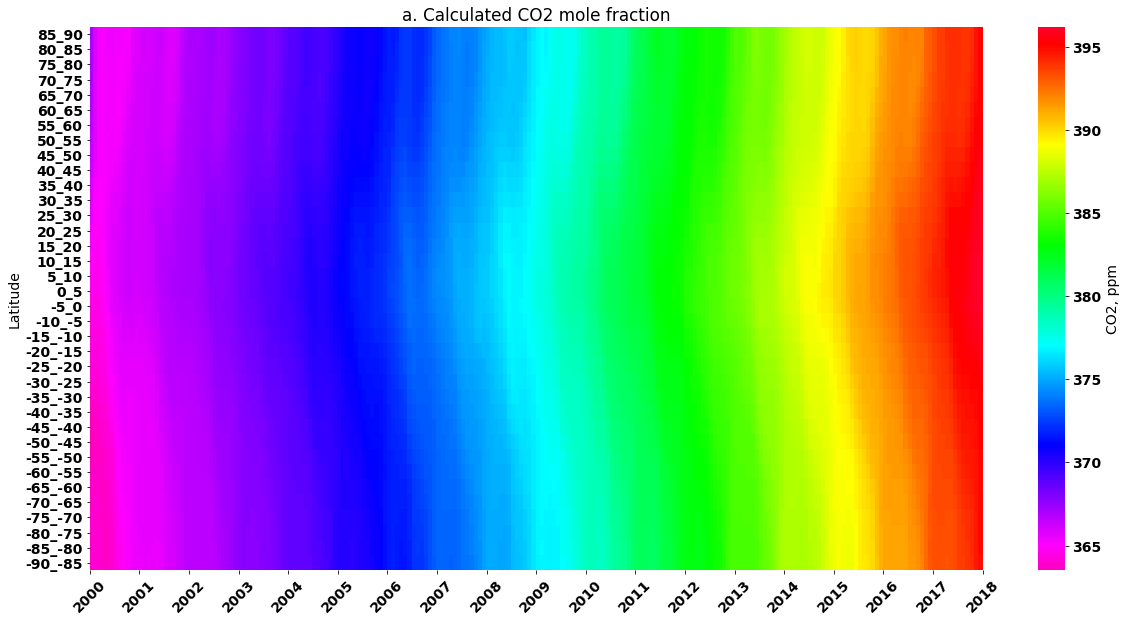

In [11]:
# Plot CO2 mole fraction zonal map
zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2ppm.lat) & (df_co2ppm.lat<= i+zonal_deg)
    temp_cal = df_co2ppm.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,2:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow_r"), cbar_kws={'label': 'CO2, ppm'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 mole fraction");

<a name="co2_molefraction_level"></a>
# 3.2. Zonal CO2 mole fraction changes with level (lv1 to lv25) in 2017

In [12]:
arr_co2ppm_4d_2017 = arr_co2ppm_4d[-13:-1,:,:,:]
arr_v_4d_2017 = arr_v_4d[-13:-1,:,:,:]

arr_co2ppm_3d_2017 = np.mean(arr_co2ppm_4d_2017,axis=0)
arr_v_3d_2017 = np.mean(arr_v_4d_2017,axis=0)

# make 2D dataframe lon, lat, lv1 ... lv25
lat = pd.DataFrame(np.repeat(np.arange(89.5,-90,-1),360))
lon = pd.DataFrame(np.tile(np.arange(-179.5,180,1),(180,1)).flatten())
df_co2ppm_2017 = pd.concat([lon,lat], axis=1)
df_v_2017 = pd.concat([lon,lat], axis=1)
for lv in range(arr_co2ppm_3d_2017.shape[0]):
    temp_onelv = arr_co2ppm_3d_2017[lv].flatten()
    df_co2ppm_2017 = pd.concat([df_co2ppm_2017, pd.DataFrame(temp_onelv)],axis=1)
    
    temp_onelv = arr_v_3d_2017[lv].flatten()
    df_v_2017 = pd.concat([df_v_2017, pd.DataFrame(temp_onelv)],axis=1)

df_co2ppm_2017.columns = ["lon", "lat"] + ["lv"+ str(i) for i in range(1,26)]
df_v_2017.columns = ["lon", "lat"] + ["lv"+ str(i) for i in range(1,26)]


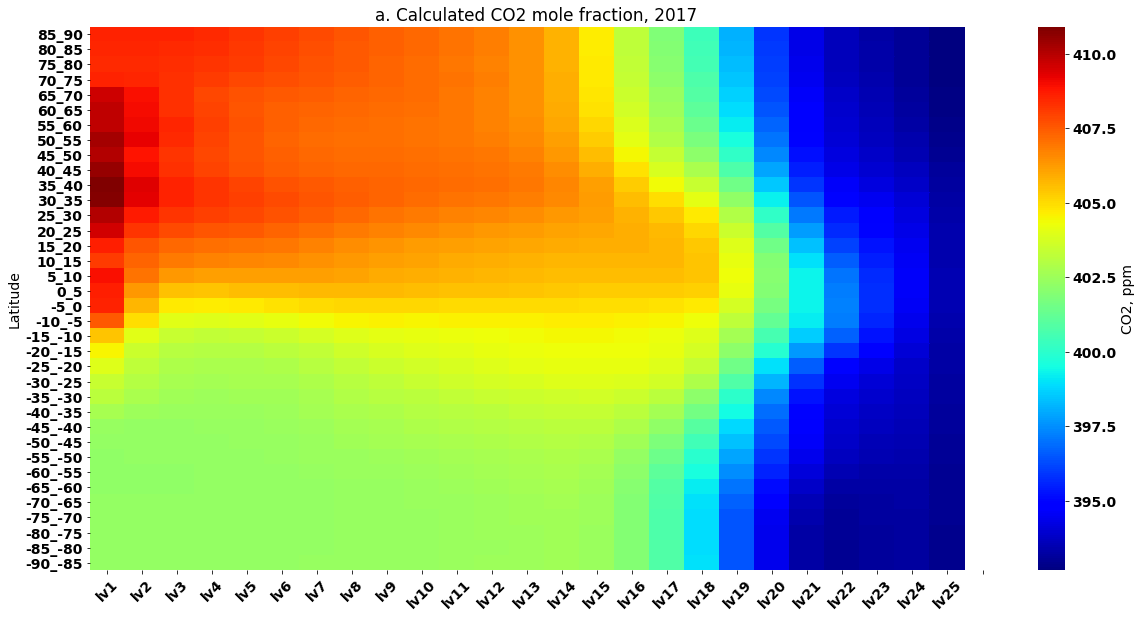

In [13]:
# Plot CO2 mole fraction zonal map
zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2ppm_2017.lat) & (df_co2ppm_2017.lat<= i+zonal_deg)
    temp_cal = np.sum(df_co2ppm_2017.loc[lat_id].iloc[:,2:]*df_v_2017.loc[lat_id].iloc[:,2:],axis=0)/np.sum(df_v_2017.loc[lat_id].iloc[:,2:],axis=0)
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i+0.5 for i in range(26)]
xticklabels = ["lv"+ str(i) for i in range(1,26)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("jet"), cbar_kws={'label': 'CO2, ppm'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 mole fraction, 2017");

In [172]:
fig, ax = plt.subplots(figsize=(16,8))

def animate(i):
    plt.clf()
    data = pd.DataFrame(arr_co2ppm_3d_2017[i,:,:])
    g = sns.heatmap(data, cmap=plt.get_cmap("jet"), cbar_kws={'label': 'CO2, ppm'}, vmin=395, vmax=445)
    g.set_xticks([i for i in range(0,361,10)])
    g.set_xticklabels([i for i in range(-180,181,10)], rotation=45) 
    g.set_yticks([i for i in range(0,181,5)])
    g.set_yticklabels([i for i in range(-90,91,5)])
    g.set_xlabel("Lon")
    g.set_ylabel("Lat")
    return g,

anim = animation.FuncAnimation(fig,animate,frames=25,interval=400);
anim.save('co2_change_with_lv.mp4', writer = 'ffmpeg', fps = 60)
HTML(anim.to_html5_video())
plt.close()

In [173]:
HTML(anim.to_html5_video())

<a name="vertical_co2_molefraction"></a>
# 3.3. Vertical CO2 mole fractoin distribution from surface to 200000m (level1 to level25)

In [14]:
# volumne weighted average CO2 mole fraction in each level, 
arr_v_2d = np.sum(arr_v_4d,axis=(2,3))
arr_co2ppm_2d = np.sum(arr_v_4d*arr_co2ppm_4d,axis=(2,3))/arr_v_2d

# CO2 mole fraction in all levels
df_co2_levels = pd.DataFrame(arr_co2ppm_2d.T)
df_co2_levels.columns = [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_co2_levels.index = ["lv"+ str(i) for i in range(1,26)]
df_co2_levels_annual = df_co2_levels[:].T
df_co2_levels_annual["year"] = df_datetime.date.dt.year.tolist()
df_co2_levels_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
lv1,370.593083,371.936858,373.987990,376.593421,378.426598,380.593165,382.711224,384.464938,386.447217,387.997451,390.348864,392.043944,394.285554,397.118075,399.167556,401.242952,404.443700,406.992638
lv2,369.612636,370.952688,373.020195,375.600976,377.454767,379.562743,381.706743,383.504114,385.431542,386.940590,389.279508,391.180279,393.338473,396.084788,398.092659,400.215969,403.385530,405.937410
lv3,369.191881,370.516733,372.592793,375.165578,377.026775,379.110881,381.268873,383.076926,384.991751,386.487690,388.816041,390.787662,392.912756,395.632579,397.628675,399.759955,402.916098,405.476146
lv4,369.067968,370.380013,372.453924,375.026910,376.889064,378.963148,381.128525,382.936119,384.856141,386.347077,388.672168,390.648222,392.766398,395.487010,397.484112,399.604766,402.756121,405.326163
lv5,369.032592,370.332413,372.402085,374.974511,376.842981,378.911030,381.080616,382.885260,384.807603,386.295868,388.624545,390.591513,392.712898,395.434181,397.436400,399.543128,402.691410,405.272345
lv6,369.012963,370.298419,372.366760,374.939617,376.814912,378.881075,381.052484,382.855077,384.774236,386.262086,388.596686,390.555516,392.679857,395.397204,397.409121,399.499281,402.644791,405.240955
lv7,369.011822,370.279079,372.347957,374.924922,376.806601,378.872189,381.046223,382.850109,384.760442,386.248718,388.593125,390.545451,392.671712,395.380301,397.405791,399.473776,402.614756,405.235993
lv8,369.024802,370.274636,372.342454,374.922077,376.812991,378.875158,381.053626,382.862559,384.764711,386.252563,388.602286,390.552962,392.680072,395.383301,397.422259,399.465697,402.602261,405.249412
lv9,369.026628,370.263623,372.329835,374.906611,376.806513,378.869471,381.050193,382.864908,384.760104,386.249512,388.595718,390.548987,392.670642,395.377273,397.423793,399.451830,402.589252,405.247489
lv10,369.017647,370.242925,372.308227,374.880318,376.789274,378.856044,381.036296,382.857176,384.741577,386.235184,388.578527,390.535195,392.648104,395.361245,397.411550,399.429683,402.566958,405.233773


In [15]:
# Level 1 CO2 mole fraction vs the global mean from all levels
co2_1vsall_month = pd.concat([co2ppm_annual.global_co2ppm, df_co2_levels_annual.lv1, co2ppm_annual_lv1_3.global_co2ppm],axis=1)
co2_1vsall_month.columns = ["lv_all", "lv_1", "lv_1_3"]
co2_1vsall_month["year"] = df_datetime.date.dt.year.tolist()
co2_1vsall_month.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
lv_all,365.207395,366.283080,367.315218,368.465005,369.627915,371.074853,372.691767,374.408791,376.067508,377.926703,379.991008,382.091426,383.965765,386.058517,388.173047,390.307248,392.412208,394.475837
lv_1,370.593083,371.936858,373.987990,376.593421,378.426598,380.593165,382.711224,384.464938,386.447217,387.997451,390.348864,392.043944,394.285554,397.118075,399.167556,401.242952,404.443700,406.992638
lv_1_3,369.458765,370.836218,372.868143,375.471747,377.305030,379.374881,381.576675,383.301305,385.327081,386.773268,389.093544,391.026098,393.165288,395.914973,397.917506,400.040713,403.215286,405.787312


year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
lv_all,NaN,1.075685,1.032138,1.149787,1.162910,1.446938,1.616914,1.717024,1.658717,1.859195,2.064306,2.100417,1.874339,2.092752,2.114531,2.134201,2.104960,2.063629
lv_1,NaN,1.343775,2.051132,2.605432,1.833177,2.166567,2.118059,1.753714,1.982279,1.550234,2.351412,1.695080,2.241610,2.832521,2.049481,2.075396,3.200747,2.548938
lv_1_3,NaN,1.377453,2.031925,2.603604,1.833283,2.069851,2.201794,1.724629,2.025776,1.446188,2.320275,1.932554,2.139190,2.749685,2.002533,2.123207,3.174573,2.572027
ctraker_obs,NaN,1.340594,2.052809,2.523899,1.943402,2.109411,2.164121,1.799294,1.991119,1.437740,2.409123,1.919972,2.057230,2.797770,2.062327,2.072489,3.119148,NaN
wdcgg_obs_noaa,NaN,1.463288,1.952791,2.423524,1.735009,2.106679,2.089555,1.826520,2.041627,1.569345,2.225082,1.934068,2.177748,2.649002,1.898997,2.356687,3.266086,2.208692
wdcgg_obs_mikio,NaN,1.515558,1.963728,2.313462,1.839787,2.056790,2.065208,1.876983,1.974337,1.639808,2.130902,2.038378,2.183897,2.533882,2.009373,2.401284,3.078044,2.312449


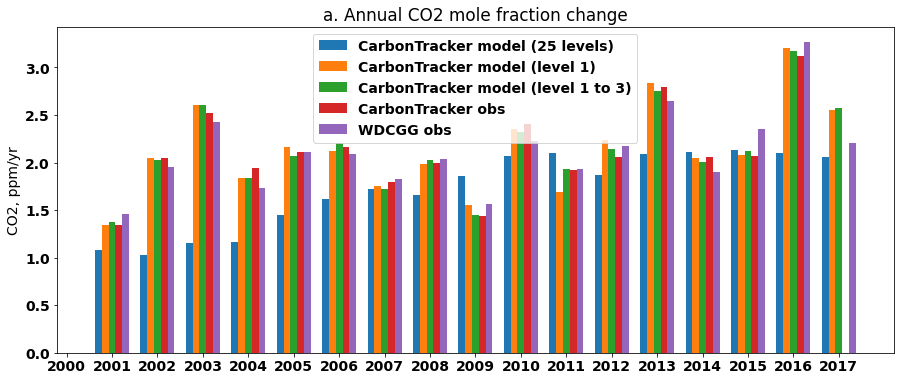

In [16]:
# plot CO2 mole fraction changes each year
df_annual_ctracker = pd.read_csv("../data/ctracker_obs/df_annual_global_NH_SH_ctracker.csv", index_col=0)
df_annual_wdcgg_noaa = pd.read_csv("../data/wdcgg_obs/df_annual_global_NH_SH_wdcgg_noaa.csv", index_col=0)
df_annual_wdcgg_mikio = pd.read_csv("../data/wdcgg_obs/df_annual_global_NH_SH_wdcgg_mikio.csv", index_col=0)
df_annual_wdcgg_noaa = df_annual_wdcgg_noaa.iloc[:,32:]
df_annual_wdcgg_mikio = df_annual_wdcgg_mikio.iloc[:,32:]

co2_1vsall_annual = co2_1vsall_month.groupby(["year"]).mean()
co2_1vsall_annual["ctraker_obs"] = df_annual_ctracker.loc["global_cal",:].tolist()
co2_1vsall_annual["wdcgg_obs_noaa"] = df_annual_wdcgg_noaa.loc["global_cal",:].tolist()
co2_1vsall_annual["wdcgg_obs_mikio"] = df_annual_wdcgg_mikio.loc["global_cal",:].tolist()
co2_annual_change = co2_1vsall_annual.diff(axis=0)

x = np.arange(co2_annual_change.shape[0])  
width = 0.15  

fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width*2, co2_annual_change.lv_all, width, label='CarbonTracker model (25 levels)')
rects2 = ax.bar(x - width, co2_annual_change.lv_1, width, label='CarbonTracker model (level 1)')
rects3 = ax.bar(x, co2_annual_change.lv_1_3, width, label='CarbonTracker model (level 1 to 3)')
rects4 = ax.bar(x + width, co2_annual_change.ctraker_obs, width, label='CarbonTracker obs')
rects5 = ax.bar(x + width*2, co2_annual_change.wdcgg_obs_noaa, width, label='WDCGG obs')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('CO2, ppm/yr')
ax.set_title('a. Annual CO2 mole fraction change')
ax.set_xticks(x)
ax.set_xticklabels(co2_annual_change.index)
ax.legend();
co2_annual_change.T

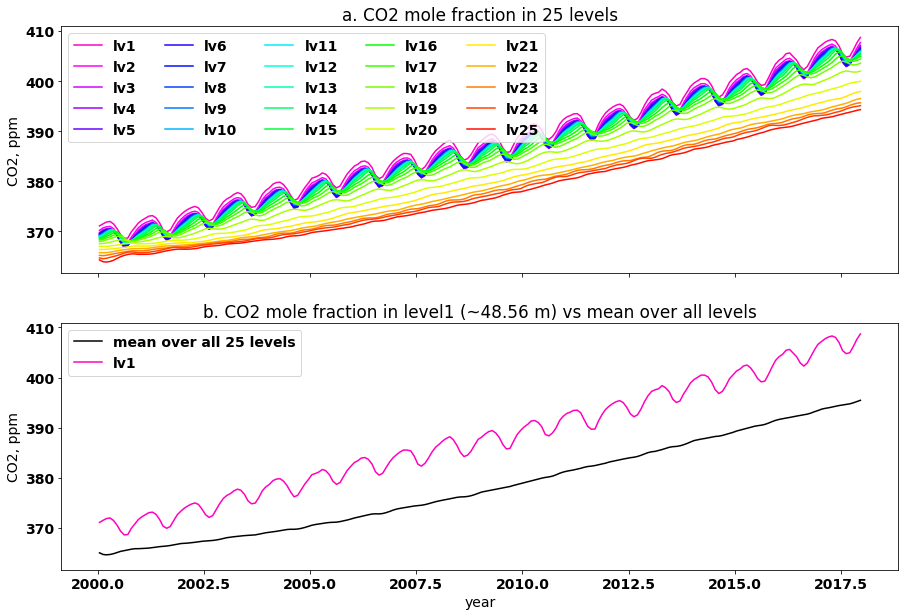

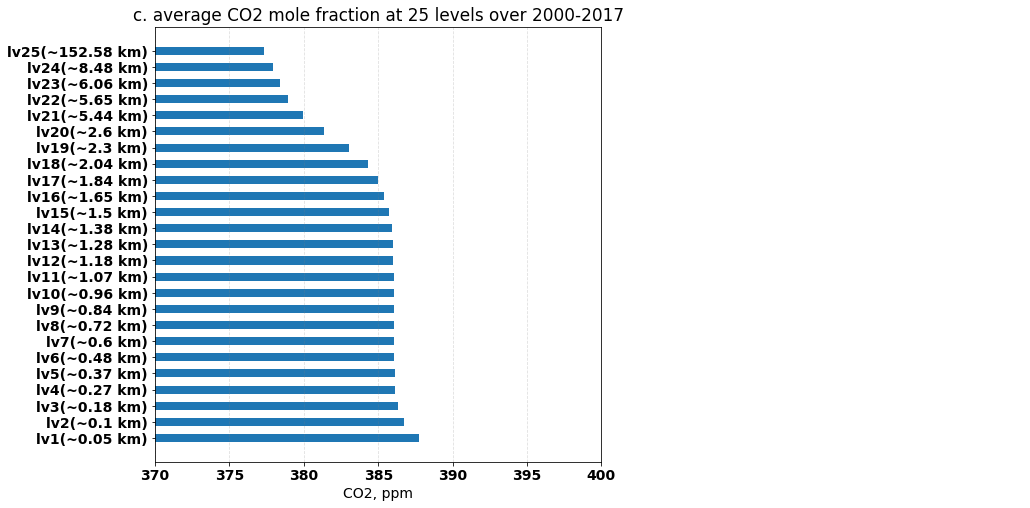

In [33]:
# plot co2 in all levels
x_decimalyear = df_datetime.decimalyear

cmap=plt.get_cmap("gist_rainbow_r")

fig,axis = plt.subplots(nrows=2,ncols=1, sharex=True, sharey=True, figsize = (15,10))
(ax1,ax2) = axis

for i in range(25):
    ax1.plot(x_decimalyear,df_co2_levels.iloc[i,:], label = "lv"+str(i+1), color=cmap(i/25))
ax1.legend(ncol=5)
ax1.set_ylabel("CO2, ppm")
ax1.set_title("a. CO2 mole fraction in 25 levels");

ax2.plot(x_decimalyear,co2_1vsall_month.iloc[:,0], label = "mean over all 25 levels", color="black")
ax2.plot(x_decimalyear,co2_1vsall_month.iloc[:,1], label = "lv"+str(1), color=cmap(0/25))
ax2.set_xlabel("year")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. CO2 mole fraction in level1 (~48.56 m) vs mean over all levels");

# ax3 = fig.add_subplot(1,3,3, aspect = "equal")  #Share y-axes with subplot 1

fig,axis = plt.subplots( figsize = (8,8))
pos = np.arange(df_co2_levels.shape[0])
rects = axis.barh(pos, df_co2_levels.mean(axis=1),
                     align='center',
                     height=0.5,
                     tick_label=df_co2_levels.index.to_list())
axis.set_xlabel("CO2, ppm")
axis.set_xlim([370, 400])
axis.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
axis.set_title("c. average CO2 mole fraction at 25 levels over 2000-2017")
yticklabels = [item.get_text() for item in axis.get_yticklabels()]
yticklabels = [yticklabels[i] + "("+ level_height_label[i] + ")" for i in range(len(yticklabels))]
axis.set_yticklabels(yticklabels)

autolabel(rects, axis, addition=["  ("+level_alt_label[i]+")" for i in range(len(level_alt_label))], away=35, direction=1)


<a name="sample_molefraction"></a>
# 3.4. If samples (station measurement) present whole global

In [6]:
# load data
arr_co2ppm_4d = np.load(IN_PATH+'arr_co2ppm_4d.npy') # ppm
arr_co2ppm_4d = np.flip(arr_co2ppm_4d, 2)

arr_s_4d = np.load(IN_PATH+'arr_s_4d.npy') # km2
arr_s_4d = np.flip(arr_s_4d, 2)

# volumn weighted average CO2 mole fraction
arr_co2ppm_level1 = arr_co2ppm_4d[:,0,:,:]
arr_s_level1 = arr_s_4d[:,0,:,:]

# make 2D dataframe lon, lat, month1 ... monthn
lat = pd.DataFrame(np.repeat(np.arange(89.5,-90,-1),360))
lon = pd.DataFrame(np.tile(np.arange(-179.5,180,1),(180,1)).flatten())
df_co2ppm = pd.concat([lon,lat], axis=1)
df_s = pd.concat([lon,lat], axis=1)

for mon in range(arr_co2ppm_level1.shape[0]):
    temp_onemonth = arr_co2ppm_level1[mon].flatten()
    df_co2ppm = pd.concat([df_co2ppm, pd.DataFrame(temp_onemonth)],axis=1)
    temp_onemonth = arr_s_level1[mon].flatten()
    df_s = pd.concat([df_s, pd.DataFrame(temp_onemonth)],axis=1)

df_co2ppm.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_s.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

In [7]:
# find center coordination of 1x1 grid where stations locate
df_meta = pd.read_csv(IN_PATH+"df_meta_selected_ctracker_update.csv")
lonlat_1x1 = df_meta[['lon', 'lat']]
lonlat_1x1 = lonlat_1x1.loc[~(abs(lonlat_1x1.lon)>180),:]
lonlat_1x1.loc[lonlat_1x1.lon>=0,"lonadd"] = 0.5
lonlat_1x1.loc[lonlat_1x1.lon<0,"lonadd"] = -0.5
lonlat_1x1.loc[lonlat_1x1.lat>=0,"latadd"] = 0.5
lonlat_1x1.loc[lonlat_1x1.lat<0,"latadd"] = -0.5
lonlat_1x1["newlon"] = lonlat_1x1.lon.astype(int)+lonlat_1x1.lonadd
lonlat_1x1["newlat"] = lonlat_1x1.lat.astype(int)+lonlat_1x1.latadd


In [8]:
# extract sample data from global grids
df_samples = pd.DataFrame()
for i in range(lonlat_1x1.shape[0]):
    for j in range(df_co2ppm.shape[0]):
        cond1 = abs(lonlat_1x1.iloc[i,4] - df_co2ppm.lon[j]) <0.01
        cond2 = abs(lonlat_1x1.iloc[i,5] - df_co2ppm.lat[j]) <0.01
        
        if cond1 and cond2:
            df_samples = pd.concat([df_samples,df_co2ppm.iloc[j,:]],axis=1)
            break
        
        if j % 20000 == 0:
            print(f"({i},{j})", end="...")
df_samples = df_samples.T

(0,0)...(0,20000)...(1,0)...(1,20000)...(2,0)...(3,0)...(4,0)...(5,0)...(6,0)...(7,0)...(7,20000)...(7,40000)...(8,0)...(9,0)...(10,0)...(11,0)...(11,20000)...(11,40000)...(12,0)...(12,20000)...(13,0)...(13,20000)...(14,0)...(15,0)...(16,0)...(17,0)...(18,0)...(18,20000)...(19,0)...(20,0)...(20,20000)...(20,40000)...(21,0)...(22,0)...(22,20000)...(23,0)...(23,20000)...(24,0)...(24,20000)...(25,0)...(26,0)...(27,0)...(28,0)...(29,0)...(30,0)...(31,0)...(32,0)...(33,0)...(33,20000)...(34,0)...(34,20000)...(34,40000)...(35,0)...(36,0)...(37,0)...(37,20000)...(38,0)...(39,0)...(40,0)...(41,0)...(42,0)...(42,20000)...(42,40000)...(43,0)...(43,20000)...(44,0)...(45,0)...(45,20000)...(45,40000)...(46,0)...(46,20000)...(46,40000)...(47,0)...(48,0)...(48,20000)...(48,40000)...(49,0)...(49,20000)...(50,0)...(51,0)...(52,0)...(53,0)...(53,20000)...(53,40000)...(54,0)...(55,0)...(56,0)...(57,0)...(58,0)...(59,0)...(60,0)...(61,0)...(62,0)...(63,0)...(64,0)...(64,20000)...(65,0)...(65,20000)...(66,

In [11]:
# calculate NH, global, SH mean
zonal_deg = 30
area_lat = pd.DataFrame(arr_s_level1[0,:,0])
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/1)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_all = pd.DataFrame()
df_zonal_sample = pd.DataFrame() 
for i in lat_range:
    lat_id = (i < df_co2ppm.lat) & (df_co2ppm.lat<= i+zonal_deg)
    temp_all = df_co2ppm.loc[lat_id,:]
    
    lat_id = (i < df_samples.lat) & (df_samples.lat<= i+zonal_deg)
    temp_sample = df_samples.loc[lat_id,:]
    
    df_zonal_all = pd.concat([df_zonal_all,  pd.DataFrame(temp_all.iloc[:,2:].mean()).T] )
    df_zonal_sample = pd.concat([df_zonal_sample,  pd.DataFrame(temp_sample.iloc[:,2:].mean()).T] )

df_zonal_all["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_sample["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_all.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_all = df_zonal_all.loc[:,cols_new]
df_zonal_sample = df_zonal_sample.loc[:,cols_new]
df_zonal_all = df_zonal_all.iloc[::-1] 
df_zonal_sample = df_zonal_sample.iloc[::-1] 
df_zonal_all = df_zonal_all.set_index(["lat"])
df_zonal_sample = df_zonal_sample.set_index(["lat"])

global_weight = np.array(global_weight.set_axis(df_zonal_all.index))
NH_weight = np.array(NH_weight.set_axis(df_zonal_all.index[:3]))
SH_weight = np.array(SH_weight.set_axis(df_zonal_all.index[3:]))

# raw global weighted average
global_co2_all = df_zonal_all.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_all = df_zonal_all.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_all = df_zonal_all.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculated global weighted average
global_co2_sample = df_zonal_sample.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_sample = df_zonal_sample.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_sample = df_zonal_sample.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2_all.index)[0],format='%Y-%m-%d')
co2_monthly = pd.concat([global_co2_all,NH_co2_all,SH_co2_all,global_co2_sample,NH_co2_sample,SH_co2_sample],axis=1)
co2_monthly.columns = ["global_all","NH_all","SH_all","global_sample","NH_sample","SH_sample"]
co2_monthly["year"] = datetime.dt.year.tolist()
co2_annual = co2_monthly.groupby(["year"]).mean().T
co2_annual

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_all,370.552287,371.902998,373.950677,376.553383,378.387135,380.545938,382.667393,384.417155,386.413649,387.947628,390.301550,392.018364,394.250652,397.078993,399.117123,401.199431,404.398399,406.945961
NH_all,372.442739,373.762346,375.696609,378.529318,380.344230,382.510461,384.946248,386.416117,388.577930,390.105243,392.691851,394.559709,396.702586,399.429625,401.544383,403.529800,406.857389,409.673083
SH_all,368.661835,370.043650,372.204746,374.577448,376.430041,378.581415,380.388538,382.418192,384.249367,385.790014,387.911249,389.477018,391.798717,394.728361,396.689863,398.869061,401.939410,404.218839
global_sample,371.563327,372.638341,374.914469,377.727260,379.651729,381.693237,383.561416,385.513933,387.722465,389.076867,391.209752,393.199874,395.275499,398.146203,400.213663,402.369421,405.444306,408.124775
NH_sample,374.770009,375.565012,377.966657,381.196435,383.087144,385.072369,387.039006,388.867663,391.467461,392.540900,394.764474,396.851354,398.844150,401.816942,403.848716,406.067486,409.124114,412.263498
SH_sample,368.356644,369.711670,371.862281,374.258085,376.216314,378.314106,380.083827,382.160203,383.977470,385.612834,387.655029,389.548393,391.706849,394.475464,396.578611,398.671356,401.764497,403.986052


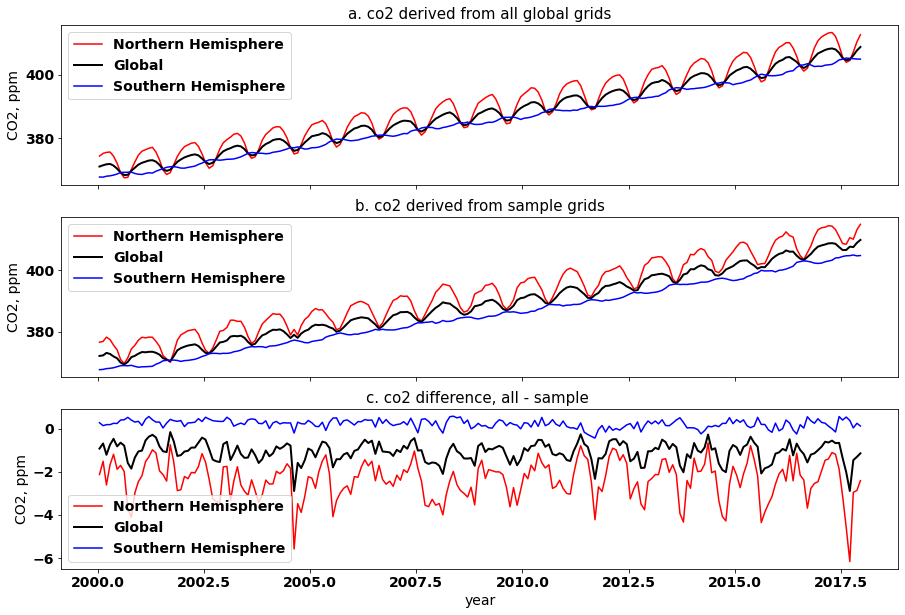

In [12]:
# plot NH, global, SH mean
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,NH_co2_all, 'r', label = "Northern Hemisphere")
ax1.plot(x_decimalyear,global_co2_all, 'k', label = "Global", lw=2)
ax1.plot(x_decimalyear,SH_co2_all,'b', label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. co2 derived from all global grids",fontsize=15)

ax2.plot(x_decimalyear,NH_co2_sample, 'r', label = "Northern Hemisphere")
ax2.plot(x_decimalyear,global_co2_sample, 'k', label = "Global", lw=2)
ax2.plot(x_decimalyear,SH_co2_sample,'b', label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. co2 derived from sample grids",fontsize=15)

ax3.plot(x_decimalyear,NH_co2_all - NH_co2_sample, 'r', label = "Northern Hemisphere")
ax3.plot(x_decimalyear,global_co2_all - global_co2_sample, 'k', label = "Global", lw=2)
ax3.plot(x_decimalyear,SH_co2_all - SH_co2_sample,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. co2 difference, all - sample ",fontsize=15);

In [14]:
# calculate difference between all and samples
diff_monthly = pd.concat([co2_monthly.NH_all-co2_monthly.NH_sample,
                          co2_monthly.global_all-co2_monthly.global_sample,
                          co2_monthly.SH_all-co2_monthly.SH_sample],axis=1)
diff_monthly.columns = ["NH","global","SH"]
diff_monthly.agg(["mean", "std"])

,NH,global,SH
mean,-2.379651,-1.077657,0.224338
std,0.881128,0.444336,0.195244


In [15]:
# # for growth rate plot
# trendp = filt.getTrendValue(xp)
# tck = sp.interpolate.splrep(x0, y4)
# trend_spl = sp.interpolate.splev(x0, tck)
# trend_der1 = sp.interpolate.splev(x0, tck, der=1)
# if ifplot and station_patten in pre_filename:
#     plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station)

In [16]:
co2_annual.T.agg(["mean", "std"])

,global_all,NH_all,SH_all,global_sample,NH_sample,SH_sample
mean,387.702706,389.906648,385.498765,388.780363,392.286299,385.274427
std,11.247829,11.497008,10.999876,11.289544,11.525194,11.055656
